In [256]:
# ! module load mambaforge
# ! mamba create -n wind_forecasting_env python=3.12
# ! mamba activate wind_forecasting_env
# ! conda install -c conda-forge jupyterlab mpi4py impi_rt
# ! pip install ./OpenOA # have to change pyproject.toml to allow for python 3.12.7
# ! pip install floris polars windrose netCDF4 statsmodels h5pyd seaborn pyarrow memory_profiler

#%load_ext memory_profiler
from data_loader import DataLoader
from data_filter import DataFilter
from data_inspector import DataInspector
from openoa.utils import qa, plot, filters, power_curve, imputing
import polars.selectors as cs
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import platform
import os
import re
import pandas as pd

import datetime
t2 = datetime.datetime(2022, 3, 1, 12, 0, 55)

## Print NetCDF Data Structure, Load Data, Transform Datetime Columns

In [257]:
PLOT = False
RELOAD_DATA = False

if platform == "darwin":
    DATA_DIR = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data"
    # PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.zo2.b0.raw.parquet"
    # FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/short_kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.2022030*.*.*.nc"
    MULTIPROCESSOR = "cf"
    TURBINE_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/gch_KP_v4.yaml"
elif platform == "linux":
    DATA_DIR = "/pl/active/paolab/awaken_data/kp.turbine.z02.b0/"
    PL_SAVE_PATH = "/scratch/alpine/aohe7145/awaken_data/kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    MULTIPROCESSOR = "mpi"
    TURBINE_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/gch_KP_v4.yaml"

DT = 5

turbine_ids =  ["wt028", "wt033", "wt073"]
#
data_loader = DataLoader(data_dir=DATA_DIR, file_signature=FILE_SIGNATURE, multiprocessor=MULTIPROCESSOR, save_path=PL_SAVE_PATH, dt=DT,
                         desired_feature_types=["time", "turbine_id", "turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"],
                         ffill_limit=int(60 * 60 * 10 // DT))

In [258]:
data_loader.print_netcdf_structure(data_loader.file_paths[0])

2024-10-18 15:34:20,684 - INFO - 📊 NetCDF File: kp.turbine.z02.b0.20220301.000000.wt028.nc
2024-10-18 15:34:20,684 - INFO - 
🌐 Global Attributes:
2024-10-18 15:34:20,685 - INFO - 
📏 Dimensions:
2024-10-18 15:34:20,685 - INFO -   date: 244573
2024-10-18 15:34:20,685 - INFO -   string7: 7
2024-10-18 15:34:20,685 - INFO - 
🔢 Variables:
2024-10-18 15:34:20,685 - INFO -   Flag:
2024-10-18 15:34:20,686 - INFO -     Dimensions: ('date', 'string7')
2024-10-18 15:34:20,686 - INFO -     Shape: (244573, 7)
2024-10-18 15:34:20,686 - INFO -     Data type: |S1
2024-10-18 15:34:20,686 - INFO -     Attributes:
2024-10-18 15:34:20,687 - INFO -       _Encoding: utf-8
2024-10-18 15:34:20,687 - INFO -   date:
2024-10-18 15:34:20,687 - INFO -     Dimensions: ('date',)
2024-10-18 15:34:20,687 - INFO -     Shape: (244573,)
2024-10-18 15:34:20,687 - INFO -     Data type: int32
2024-10-18 15:34:20,687 - INFO -     Attributes:
2024-10-18 15:34:20,688 - INFO -       units: milliseconds since 2022-03-01 00:00:00.

In [259]:
if not RELOAD_DATA and os.path.exists(data_loader.save_path):
    # Note that the order of the columns in the provided schema must match the order of the columns in the CSV being read.
    
    schema = pl.Schema({**{"time": pl.Datetime(time_unit="ms")},
                        **{
                            f"{feat}_{tid}": pl.Float64
                            for feat in ["turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"] 
                            for tid in [f"wt{d+1:03d}" for d in range(88)]}
                        })
    
    df_query = pl.scan_parquet(source=data_loader.save_path, hive_schema=schema)
    data_loader.available_features = sorted(df_query.collect_schema().names())
    data_loader.turbine_ids = sorted(np.unique([re.findall(f"(?<=wind_direction_)(.*)", feat)[0] for feat in data_loader.available_features if "wind_direction" in feat]))
else:
    df_query = data_loader.read_multi_netcdf()

## Plot Wind Farm, Data Distributions

In [260]:
data_inspector = DataInspector(turbine_input_filepath=TURBINE_INPUT_FILEPATH, farm_input_filepath=FARM_INPUT_FILEPATH)

In [261]:
if PLOT and False:
    data_inspector.plot_wind_farm()

In [262]:
if PLOT:
    data_inspector.plot_wind_speed_power(df_query, turbine_ids=["wt073"])

In [263]:
if PLOT:
    data_inspector.plot_wind_speed_weibull(df_query, turbine_ids=["wt073"])

In [264]:
if PLOT:
    data_inspector.plot_wind_rose(df_query, turbine_ids=["wt073"])

In [265]:
if PLOT:
    data_inspector.plot_correlation(df_query, 
    DataInspector.get_features(df_query, feature_types=["wind_speed", "wind_direction", "nacelle_direction"], turbine_ids=["wt073"]))

In [266]:
if PLOT:
    data_inspector.plot_boxplot_wind_speed_direction(df_query, turbine_ids=["wt073"])

In [267]:
if PLOT:
    data_inspector.plot_time_series(df_query, turbine_ids=["wt073"])

In [268]:
# from datetime import timedelta
# idx = np.where(df_query.select(pl.col("time")).collect(streaming=True).to_series().diff().to_numpy() != np.timedelta64(5, 's'))[0]
# idx

# df_query.select(pl.col("time")).filter(pl.col("time").diff() != np.timedelta64(5, 's')).collect(streaming=True)
# df_query.select("time", "wind_direction_wt073").filter(pl.col("wind_direction_wt073").is_null()).collect(streaming=True)
# df_query.select("time", "power_output_wt073").filter(pl.col("power_output_wt073").is_null()).collect(streaming=True)
# from datetime import datetime
# df_query.select("time", "wind_direction_wt073").filter((pl.col("time") >= datetime.strptime("2022-03-09 00:00:00", '%Y-%m-%d %H:%M:%S')) 
#                                                     & (pl.col("time") <= datetime.strptime("2022-03-17 00:00:00", '%Y-%m-%d %H:%M:%S'))).collect(streaming=True)

## OpenOA Data Preparation & Inspection

In [269]:
ws_cols = DataInspector.get_features(df_query, "wind_speed")
wd_cols = DataInspector.get_features(df_query, "wind_direction")
pwr_cols = DataInspector.get_features(df_query, "power_output")

In [270]:
print(f"Features of interest = {data_loader.desired_feature_types}")
print(f"Available features = {data_loader.available_features}")
# qa.describe(DataInspector.collect_data(df=df_query))

Features of interest = ['time', 'turbine_id', 'turbine_status', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']
Available features = ['nacelle_direction_wt028', 'nacelle_direction_wt033', 'nacelle_direction_wt073', 'power_output_wt028', 'power_output_wt033', 'power_output_wt073', 'time', 'turbine_status_wt028', 'turbine_status_wt033', 'turbine_status_wt073', 'wind_direction_wt028', 'wind_direction_wt033', 'wind_direction_wt073', 'wind_speed_wt028', 'wind_speed_wt033', 'wind_speed_wt073']


In [271]:
if PLOT:
    plot.column_histograms(DataInspector.collect_data(df=df_query, 
    feature_types=DataInspector.get_features(df_query, ["wind_speed", "wind_direction", "power_output", "nacelle_direction"], ["wt073", "wt028", "wt033"])))

In [272]:
data_filter = DataFilter(turbine_availability_col=None, turbine_status_col="turbine_status")

In [273]:
df_query.filter(pl.col("time") <= t2).collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-01 12:00:35,1.0,1.0,5.0,214.0,218.0,248.0,9.591759,6.175363,8.285666,2699.716,1293.08472,2169.47632,219.0,219.0,256.0
2022-03-01 12:00:40,5.0,5.0,5.0,214.0,218.0,248.0,9.591759,6.175363,8.285666,2699.716,1293.08472,2169.47632,219.0,219.0,256.0
2022-03-01 12:00:45,5.0,5.0,5.0,220.0,218.0,254.0,9.591759,6.175363,8.285666,2699.716,1293.08472,2169.47632,219.0,219.0,256.0


### Nullify Inoperational Turbine Rows

In [274]:
# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
# df_query = data_filter.filter_inoperational(df_query, status_codes=[1], include_nan=False)
status_codes = [1]
mask = lambda tid: pl.col(f"turbine_status_{tid}").is_in(status_codes) | pl.col(f"turbine_status_{tid}").is_null()
features = ws_cols + pwr_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, ws_cols + wd_cols, ["wind_speed", "wind_direction"], ["Wind Speed [m/s]", "Wind Direction [deg]"])


Feature wind_speed_wt028 has 70.7668427645553 % unfiltered values.
Feature wind_speed_wt033 has 67.90139425957193 % unfiltered values.
Feature wind_speed_wt073 has 60.64076030717281 % unfiltered values.
Feature power_output_wt028 has 70.7668427645553 % unfiltered values.
Feature power_output_wt033 has 67.90139425957193 % unfiltered values.
Feature power_output_wt073 has 60.64076030717281 % unfiltered values.


In [275]:
# df_query.select(f"power_output_wt073").collect(streaming=True).to_pandas().isna().sum() 
# df_query.head().collect()
df_query.filter(pl.col("time") <= t2).collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-01 12:00:35,1.0,1.0,5.0,214.0,218.0,248.0,9.591759,6.175363,8.285666,2699.716,1293.08472,2169.47632,219.0,219.0,256.0
2022-03-01 12:00:40,5.0,5.0,5.0,214.0,218.0,248.0,9.591759,6.175363,8.285666,2699.716,1293.08472,2169.47632,219.0,219.0,256.0
2022-03-01 12:00:45,5.0,5.0,5.0,220.0,218.0,254.0,9.591759,6.175363,8.285666,2699.716,1293.08472,2169.47632,219.0,219.0,256.0


In [276]:
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
# fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, ws_cols + wd_cols)

JS Score for feature wind_speed_wt028 = 0.02328274567179356
JS Score for feature wind_speed_wt033 = 0.03544794843578207
JS Score for feature wind_speed_wt073 = 0.03692474764361267
JS Score for feature wind_direction_wt028 = 0.01216459200845605
JS Score for feature wind_direction_wt033 = 0.01136192489625543
JS Score for feature wind_direction_wt073 = 0.016380549342631497


In [277]:
df_query.head().collect()
df_query.filter(pl.col("time") <= t2).collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-01 12:00:35,1.0,1.0,5.0,214.0,218.0,null,9.591759,6.175363,null,2699.716,1293.08472,2169.47632,219.0,219.0,256.0
2022-03-01 12:00:40,5.0,5.0,5.0,null,null,null,null,null,null,2699.716,1293.08472,2169.47632,219.0,219.0,256.0
2022-03-01 12:00:45,5.0,5.0,5.0,null,null,null,null,null,null,2699.716,1293.08472,2169.47632,219.0,219.0,256.0


### Wind Speed Range Filter

In [278]:

# check for wind speed values that are outside of the acceptable range
ws = DataInspector.collect_data(df=df_query, feature_types="wind_speed")
out_of_range = (filters.range_flag(ws, lower=0, upper=70) & ~ws.isna()).values # range flag includes formerly null values as nan
del ws
# qa.describe(DataInspector.collect_data(df=df_query, feature_types="wind_speed", mask=np.any(out_of_range, axis=1)))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~out_of_range[:, data_loader.turbine_ids.index(tid)]
features = ws_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, ws_cols, ["wind_speed"], ["Wind Speed [m/s]"])



Feature wind_speed_wt028 has 100.0 % unfiltered values.
Feature wind_speed_wt033 has 100.0 % unfiltered values.
Feature wind_speed_wt073 has 100.0 % unfiltered values.


In [279]:
out_of_range
# df_query.select(f"power_output_wt073").collect(streaming=True).to_pandas().isna().sum() 

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [280]:
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
# fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, ws_cols)
# df_query = df_query.with_columns(
#                 [pl.when(~out_of_range[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for feat in ws_cols]
#                 )

JS Score for feature wind_speed_wt028 = 0.0
JS Score for feature wind_speed_wt033 = 0.0
JS Score for feature wind_speed_wt073 = 0.0


In [281]:
del out_of_range 
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


### Power Curve Window Range Filter

In [282]:
# apply a window range filter to remove data with power values outside of the window from 20 to 3000 kW for wind speeds between 5 and 40 m/s.
# identifies when turbine is shut down, filtering for normal turbine operation

out_of_window = np.stack([(filters.window_range_flag(window_col=DataInspector.collect_data(df=df_query, 
                                                                                    feature_types=["wind_speed"], 
                                                                                    turbine_ids=[tid])[f"wind_speed_{tid}"],
                                                    window_start=5., window_end=40., 
                                                    value_col=DataInspector.collect_data(df=df_query, 
                                                                                    feature_types=["power_output"], 
                                                                                    turbine_ids=[tid])[f"power_output_{tid}"],
                                                    value_min=20., value_max=3000.)
                        & df_query.select(no_nulls=pl.all_horizontal(pl.col(f"wind_speed_{tid}").is_not_null(), pl.col(f"power_output_{tid}").is_not_null()))\
                                  .collect(streaming=True).to_pandas()["no_nulls"]
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="wind_speed", turbine_ids=tid).isna()
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="power_output", turbine_ids=tid).isna()
                                  ).values for tid in data_loader.turbine_ids], axis=1)


# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~out_of_window[:, data_loader.turbine_ids.index(tid)]
features = ws_cols + pwr_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, features, ["wind_speed", "power_output"], ["Wind Speed [m/s]", "Power Output [W]"])



Feature wind_speed_wt028 has 98.46890147595447 % unfiltered values.
Feature wind_speed_wt033 has 99.0700397581831 % unfiltered values.
Feature wind_speed_wt073 has 99.15377702739502 % unfiltered values.
Feature power_output_wt028 has 98.46890147595447 % unfiltered values.
Feature power_output_wt033 has 99.0700397581831 % unfiltered values.
Feature power_output_wt073 has 99.15377702739502 % unfiltered values.


In [283]:
# df_query.select(f"power_output_wt033").collect(streaming=True).to_pandas().isna().sum() 
# DataInspector.collect_data(df_query, feature_types=["time", "wind_speed", "power_output"], turbine_ids=["wt073"], mask=out_of_window[:, 2])
out_of_window

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [284]:

if PLOT:
    # plot values that are outside of power-wind speed range
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=out_of_window,
        flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )


In [285]:
# fill cells corresponding to values that are outside of power-wind speed window range with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, features)

# df_query = df_query.with_columns(
#                 [pl.when(~out_of_window[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for feat in ws_cols + pwr_cols]
# )

JS Score for feature wind_speed_wt028 = 3.541032279560565e-05
JS Score for feature wind_speed_wt033 = 3.395173905720496e-05
JS Score for feature wind_speed_wt073 = 3.1294921719538925e-05
JS Score for feature power_output_wt028 = 5.8033281632504865e-05
JS Score for feature power_output_wt033 = 1.813105959433226e-05
JS Score for feature power_output_wt073 = 1.7307610666359482e-05


In [286]:
del out_of_window
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


In [287]:
#print(df_query.collect(streaming=True).shape)

### Power Curve Bin Filter

In [288]:
# apply a bin filter to remove data with power values outside of an envelope around median power curve at each wind speed

bin_outliers = np.stack([(filters.bin_filter(
                                  bin_col=f"power_output_{tid}", 
                                  value_col=f"wind_speed_{tid}", 
                                  bin_width=50, threshold=3,
                                  center_type="median", 
                                  bin_min=20., bin_max=0.90*(df_query.select(f"power_output_{tid}").max().collect(streaming=True).item() or 3000.),
                                  threshold_type="scalar", direction="below",
                                  data=DataInspector.collect_data(df=df_query, 
                                                                  feature_types=["wind_speed", "power_output"], 
                                                                  turbine_ids=[tid])
                                  )
                                & df_query.select(no_nulls=pl.all_horizontal(pl.col(f"wind_speed_{tid}").is_not_null(), pl.col(f"power_output_{tid}").is_not_null()))\
                                  .collect(streaming=True).to_pandas()["no_nulls"]
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="wind_speed", turbine_ids=tid).isna()
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="power_output", turbine_ids=tid).isna()
                                  ).values for tid in data_loader.turbine_ids], axis=1)
# qa.describe(DataInspector.collect_data(df=df_query, feature_types=["wind_speed", "power_output"], mask=bin_outliers))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~bin_outliers[:, data_loader.turbine_ids.index(tid)]

features = ws_cols + pwr_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, features, ["wind_speed", "power_output"], ["Wind Speed [m/s]", "Power Output [W]"])

Feature wind_speed_wt028 has 99.98774576548118 % unfiltered values.
Feature wind_speed_wt033 has 99.98502260225479 % unfiltered values.
Feature wind_speed_wt073 has 99.98910734709439 % unfiltered values.
Feature power_output_wt028 has 99.98774576548118 % unfiltered values.
Feature power_output_wt033 has 99.98502260225479 % unfiltered values.
Feature power_output_wt073 has 99.98910734709439 % unfiltered values.


In [289]:
bin_outliers

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [290]:
if PLOT:
    # plot values outside the power-wind speed bin filter
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=bin_outliers,
        flag_labels=("Anomylous Data", "Normal Wind Speed Sensor Operation"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )

In [291]:
# fill cells corresponding to values that are outside of power-wind speed bins with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, features)
# df_query = df_query.with_columns(
#                 [pl.when(~bin_outliers[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for feat in ws_cols + pwr_cols]
# )

JS Score for feature wind_speed_wt028 = 1.9029505489944738e-08
JS Score for feature wind_speed_wt033 = 1.8675457807432357e-08
JS Score for feature wind_speed_wt073 = 2.747139979315346e-08
JS Score for feature power_output_wt028 = 5.220738859187891e-08
JS Score for feature power_output_wt033 = 5.837710383649833e-08
JS Score for feature power_output_wt073 = 4.389664599272941e-08


In [292]:
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


### Power Curve Fitting

In [293]:
if PLOT:
    # Fit the power curves
    iec_curve = power_curve.IEC(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(),
        )

    l5p_curve = power_curve.logistic_5_parametric(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(),
        )

    spline_curve = power_curve.gam(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(), 
        n_splines=20)

In [294]:
if PLOT:
    fig, ax = plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=np.zeros(DataInspector.collect_data(df=df_query, feature_types="wind_speed").shape, dtype=bool),
        flag_labels=("", "Filtered Power Curve"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=False,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
        return_fig=True,
    )

    x = np.linspace(0, 20, 100)
    ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
    ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
    ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

    ax.legend()

    fig.tight_layout()
    plt.show()

### Unresponsive Sensor Filter

In [295]:
# find stuck sensor measurements for each turbine and set them to null
# TODO question does unresponsive flag include nan values
# frozen_thresholds = [(data_loader.ffill_limit * i) + 1 for i in range(1, 19)]
# print(frozen_thresholds)
# ws_pcs = []
# wd_pcs = []
# pwr_pcs = []
# for thr in frozen_thresholds:
#     ws_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_speed"), threshold=thr).values
#     wd_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr).values
#     pwr_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr).values

#     # check if wind speed/dir measurements from inoperational turbines differ from fully operational
#     print(f"For a threshold of {thr} for the frozen sensor filters:")
#     ws_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, ws_cols, lambda tid: ws_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))
#     wd_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, wd_cols, lambda tid: wd_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))
#     pwr_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, pwr_cols, lambda tid: pwr_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))

# fig, ax = plt.subplots(3, 1, sharex=True)
# for t_idx in range(len(data_loader.turbine_ids)):
#     ax[0].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in ws_pcs], label=data_loader.turbine_ids[t_idx])
#     ax[1].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in wd_pcs], label=data_loader.turbine_ids[t_idx])
#     ax[2].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in pwr_pcs],label=data_loader.turbine_ids[t_idx])

# h, l = ax[0].get_legend_handles_labels()
# ax[0].legend(h[:len(data_loader.turbine_ids)], l[:len(data_loader.turbine_ids)])
# ax[0].set_title("Percentage of Unfrozen Wind Speed Measurements")
# ax[1].set_title("Percentage of Unfrozen Wind Direction Measurements")
# ax[2].set_title("Percentage of Unfrozen Power Output Measurements")
# qa.describe(pl.concat([DataInspector.collect_data(df=df_query, feature_types=feature_type, mask=mask, to_pandas=False)
#                         for mask, feature_type in zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], ["wind_speed", "wind_direction", "power_output"])], 
#                             how="horizontal")\
#                                .to_pandas())

# TODO ASK ERIC
if False:
    thr = data_loader.ffill_limit + 1
    # frozen_sensor = (filters.unresponsive_flag(data=df_query.select(features).collect(streaming=True).to_pandas(), threshold=thr)
                                    # & df_query.select([pl.col(feat).is_not_null().alias(feat) for feat in features])\
                                    #   .collect(streaming=True).to_pandas()
                                    #   ).values
    features = ws_cols + wd_cols
    # frozen_sensor = np.stack([(filters.unresponsive_flag(data=df_query.select(feat).collect(streaming=True).to_pandas(), threshold=thr)
    #                                 & df_query.select(pl.col(feat).is_not_null().alias(feat))\
    #                                 .collect(streaming=True).to_pandas()
    #                                 ).values for feat in features], axis=1)
    # find values of wind speed/direction, where there are duplicate values with nulls inbetween
    mask = lambda tid: ~frozen_sensor[:, data_loader.turbine_ids.index(tid)]

# df_query.select([pl.col(feat).is_not_null().name.suffix("_not_null") for feat in ws_cols])\
#                                   .collect(streaming=True).to_pandas()
# 
# ws_frozen_sensor = (filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_speed"), threshold=thr)
#                                 & df_query.select([pl.col(feat).is_not_null().name.suffix("_not_null") for feat in ws_cols])\
#                                   .collect(streaming=True).to_pandas()
#                                   ).values
# ws_frozen_sensor
# wd_frozen_sensor = np.stack([(filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr)
#                                 & df_query.select(no_nulls=pl.col(f"wind_speed_{tid}").is_not_null())\
#                                   .collect(streaming=True).to_pandas()["no_nulls"]
#                                   ).values for tid in data_loader.turbine_ids], axis=1)
# pwr_frozen_sensor = np.stack([(filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr)
#                                 & df_query.select(no_nulls=pl.col(f"wind_speed_{tid}").is_not_null())\
#                                   .collect(streaming=True).to_pandas()["no_nulls"]
#                                   ).values for tid in data_loader.turbine_ids], axis=1)

# wd_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr).values
# pwr_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr).values

# ws_mask = lambda tid: ~ws_frozen_sensor[:, data_loader.turbine_ids.index(tid)]
# wd_mask = lambda tid: ~wd_frozen_sensor[:, data_loader.turbine_ids.index(tid)]
# pwr_mask = lambda tid: ~pwr_frozen_sensor[:, data_loader.turbine_ids.index(tid)]


In [296]:
if False:
    frozen_sensor

In [297]:
if PLOT and False:
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=ws_frozen_sensor,
        flag_labels=(f"Wind Speed Unresponsive Sensors (n={ws_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=wd_frozen_sensor,
        flag_labels=(f"Wind Direction Unresponsive Sensors (n={wd_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=pwr_frozen_sensor,
        flag_labels=(f"Power Output Unresponsive Sensors (n={pwr_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

In [298]:
# change the values corresponding to frozen sensor measurements to null or interpolate (instead of dropping full row, since other sensors could be functioning properly)
# fill stuck sensor measurements with Null st they are marked for interpolation later,
if False:
    threshold = 0.01
    df_query = data_filter.conditional_filter(df_query, threshold, mask, features)
# df_query = df_query.with_columns(
#                 [pl.when(~frozen_mask[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for features, frozen_mask in zip(
#                     [ws_cols, wd_cols, pwr_cols], 
#                     [ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor])
#                 for feat in features]
# )

In [299]:
if False:
    del frozen_sensor

### Assess and Impute/Interpolate Turbine Missing Data from Correlated Measurements OR Split Dataset during Time Stamps for which many Turbines have Missing Data

In [300]:
df_query.head().collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null


In [301]:
# if there is a short or long gap for some turbines, impute them using the imputing.impute_all_assets_by_correlation function
#       else if there is a short or long gap for many turbines, split the dataset
missing_col_thr = max(1, int(len(data_loader.turbine_ids) * 0.10))
missing_duration_thr = np.timedelta64(1, "m")
missing_data_cols = ["wind_speed", "wind_direction"]

# check for any periods of time for which more than 'missing_col_thr' features have missing data

df_query = df_query\
        .with_columns([cs.starts_with(col).is_null().name.suffix("_is_missing") for col in missing_data_cols])\
        .with_columns(**{f"{col}_num_missing": pl.sum_horizontal((cs.starts_with(col) & cs.contains("is_missing"))) for col in missing_data_cols})

def add_df_continuity_columns(df, mask):
  # change first value of continuous_shifted to false such that add_df_agg_continuity_columns catches it as a start time for a period 
  return df\
        .filter(mask)\
        .with_columns(dt=pl.col("time").diff())\
        .with_columns(dt=pl.when(pl.int_range(0, pl.len()) == 0).then(np.timedelta64(data_loader.dt, "s")).otherwise(pl.col("dt")))\
        .select("time", "dt", cs.ends_with("num_missing"), cs.ends_with("is_missing"))\
        .with_columns(continuous=pl.col("dt")==np.timedelta64(data_loader.dt, "s"))\
        .with_columns(continuous_shifted=pl.col("continuous").shift(-1, fill_value=True))

# subset of data, indexed by time, which has <= the threshold number of missing columns
df_query_not_missing_times = add_df_continuity_columns(df_query, mask=pl.sum_horizontal(cs.ends_with("num_missing")) <= missing_col_thr)

# subset of data, indexed by time, which has > the threshold number of missing columns
df_query_missing_times = add_df_continuity_columns(df_query, mask=pl.sum_horizontal(cs.ends_with("num_missing")) > missing_col_thr)

def add_df_agg_continuity_columns(df):
  # if the continuous flag is True, but the value in the row before it False
  df = df.filter(pl.col("continuous") | (pl.col("continuous") & ~pl.col("continuous_shifted")) |  (~pl.col("continuous") & pl.col("continuous_shifted")))
  start_time_cond = ((pl.col("continuous") & ~pl.col("continuous_shifted"))).shift() | (pl.int_range(0, pl.len()) == 0)
  end_time_cond = (~pl.col("continuous") & pl.col("continuous_shifted"))
  return pl.concat([df.filter(start_time_cond).select(start_time=pl.col("time")), 
                    df.with_columns(end_time=pl.col("time").shift(1)).filter(end_time_cond).select("end_time")], how="horizontal")\
            .with_columns(duration=(pl.col("end_time") - pl.col("start_time")))\
            .sort("start_time")\
            .drop_nulls()

# start times, end times, and durations of each of the continuous subsets of data in df_query_missing_times 
df_query_missing = add_df_agg_continuity_columns(df_query_missing_times)

# start times, end times, and durations of each of the continuous subsets of data in df_query_not_missing_times 
# AND of each of the coninuous subsets of data in df_query_missing_times that are under the threshold duration time 
df_query_not_missing = pl.concat([add_df_agg_continuity_columns(df_query_not_missing_times), 
                                  df_query_missing.filter(pl.col("duration") <= missing_duration_thr)])\
                          .sort("start_time")

def get_continuity_group_index(df):
  # Create the condition for the group
  group_number = None

  # Create conditions to assign group numbers based on time ranges
  for i, (start, end) in enumerate(df.collect().select("start_time", "end_time").iter_rows()):
      # print(i, start, end, duration)
      time_cond = pl.col("time").is_between(start, end)
      if group_number is None:
          group_number = pl.when(time_cond).then(pl.lit(i))
      else:
          group_number = group_number.when(time_cond).then(pl.lit(i))
    
  # If no group is matched, assign a default value (e.g., -1) 
  group_number = group_number.when(pl.col("time") > end).then(pl.lit(i + 1))
  group_number = group_number.otherwise(pl.lit(-1))
  return group_number

def group_df_by_continuity(df, agg_df):
  group_number = get_continuity_group_index(agg_df)

  return pl.concat([agg_df, df.with_columns(group_number.alias("continuity_group"))\
          .filter(pl.col("continuity_group") != -1)\
          .group_by("continuity_group")\
          .agg(cs.ends_with("is_missing").sum())\
          .with_columns([pl.sum_horizontal(cs.starts_with(col) & cs.ends_with("is_missing")).alias(f"{col}_is_missing") for col in missing_data_cols])\
          .sort("continuity_group")], how="horizontal")

# merge rows with end times corresponding to start times of the next row into the next row, until no more rows need to be merged
while 1:
  # get the end times which should be merged with subsequent rows
  end_times_to_merge = df_query_not_missing.filter(((pl.col("end_time") + np.timedelta64(data_loader.dt, "s")) == (pl.col("start_time").shift(-1)))).collect().select("end_time")
  
  if end_times_to_merge.select(pl.len()).item() == 0:
    break
  
  # if this is the first pass, set the merge condition to all rows to merge
  # if merge_cond is None:
  df_query_not_missing = df_query_not_missing.select(pl.when(pl.col("end_time").is_in(end_times_to_merge)).then(pl.col("start_time")).alias("start_time"),
                                                     pl.when(pl.col("end_time").is_in(end_times_to_merge)).then(pl.col("end_time").shift(-1)).alias("end_time"))\
                                            .drop_nulls()
  
  # otherwise, add an or statement
  # else:
  #   merge_cond |= (pl.when(pl.col("end_time").is_in(end_times_to_merge)).then(pl.col("start_time")).alias("start_time"),
  #             pl.when(pl.col("end_time").is_in(end_times_to_merge)).then(pl.col("end_time").shift(-1)).alias("end_time"))

df_query_not_missing = df_query_not_missing.with_columns((pl.col("end_time") - pl.col("start_time")).alias("duration")).drop_nulls()
  
del end_times_to_merge

# df_query_not_missing = group_df_by_continuity(pl.concat([df_query_not_missing_times, df_query_missing_times]), df_query_not_missing)
df_query_not_missing = group_df_by_continuity(df_query, df_query_not_missing)

In [302]:
df_query.collect()

time,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073,wind_speed_wt028_is_missing,wind_speed_wt033_is_missing,wind_speed_wt073_is_missing,wind_direction_wt028_is_missing,wind_direction_wt033_is_missing,wind_direction_wt073_is_missing,wind_speed_num_missing,wind_direction_num_missing
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,bool,u32,u32
2022-03-01 00:00:00,null,null,null,210.0,214.0,null,7.267889,6.943515,6.374405,744.643555,623.3373,933.7757,null,null,null,false,false,false,false,false,true,0,1
2022-03-01 00:00:05,null,null,null,202.0,216.0,257.0,5.562267,6.483469,6.519901,749.904358,603.8363,946.6871,null,null,null,false,false,false,false,false,false,0,0
2022-03-01 00:00:10,null,null,null,209.0,207.0,253.0,5.562267,6.39619,6.519901,735.792847,614.7073,946.6871,null,null,null,false,false,false,false,false,false,0,0
2022-03-01 00:00:15,null,null,null,207.0,217.0,252.0,5.921947,5.378632,6.358075,719.4552,603.3011,945.193848,null,null,null,false,false,false,false,false,false,0,0
2022-03-01 00:00:20,null,null,null,214.0,207.0,255.0,6.552724,5.385675,6.636747,706.787231,571.158,945.193848,null,null,null,false,false,false,false,false,false,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-09 12:00:15,1.0,1.0,1.0,213.0,223.0,275.0,4.654607,3.935651,3.628343,227.234512,27.970007,146.924789,228.0,228.0,271.0,false,false,false,false,false,false,0,0
2022-03-09 12:00:20,1.0,1.0,1.0,213.0,223.0,275.0,4.654607,3.935651,3.628343,227.234512,27.970007,146.924789,228.0,228.0,271.0,false,false,false,false,false,false,0,0
2022-03-09 12:00:25,1.0,1.0,1.0,213.0,223.0,275.0,4.654607,3.935651,3.628343,227.234512,27.970007,146.924789,228.0,228.0,271.0,false,false,false,false,false,false,0,0


In [303]:
if PLOT:
  # Plot number of missing wind dir/wind speed data for each wind turbine (missing duration on x axis, turbine id on y axis, color for wind direction/wind speed)
  from matplotlib import colormaps
  from matplotlib.ticker import MaxNLocator
  fig, ax = plt.subplots(1, 1)
  for feature_type, marker in zip(missing_data_cols, ["o", "^"]):
    for turbine_id, color in zip(data_loader.turbine_ids, colormaps["tab20c"](np.linspace(0, 1, len(data_loader.turbine_ids)))):
      df = df_query_missing.select("duration", f"{feature_type}_{turbine_id}_is_missing").collect(streaming=True).to_pandas()
      ax.scatter(x=df["duration"].dt.seconds / 3600,
                  y=df[f"{feature_type}_{turbine_id}_is_missing"].astype(int),  
      marker=marker, label=turbine_id, s=400, color=color)
  ax.set_title("Occurence of Missing Wind Speed (circle) and Wind Direction (triangle) Values vs. Missing Duration, for each Turbine")
  ax.set_xlabel("Duration of Missing Values [hrs]")
  ax.set_ylabel("Number of Missing Values over this Duration")
  h, l = ax.get_legend_handles_labels()
  ax.legend(h[:len(data_loader.turbine_ids)], l[:len(data_loader.turbine_ids)])
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))

  # Plot missing duration on x axis, number of missing turbines on y-axis, marker for wind speed vs wind direction,
  fig, ax = plt.subplots(1, 1)
  for feature_type, marker in zip(missing_data_cols, ["o", "^"]):
    df = df_query_missing.select("duration", (cs.contains(feature_type) & cs.ends_with("is_missing")))\
                            .with_columns(pl.sum_horizontal([f"{feature_type}_{tid}_is_missing" for tid in data_loader.turbine_ids]).alias(f"{feature_type}_is_missing")).collect(streaming=True).to_pandas()
    ax.scatter(x=df["duration"].dt.seconds / 3600,
                y=df[f"{feature_type}_is_missing"].astype(int),  
    marker=marker, label=feature_type, s=400)
  ax.set_title("Occurence of Missing Wind Speed (circle) and Wind Direction (triangle) Values vs. Missing Duration, for all Turbines")
  ax.set_xlabel("Duration of Missing Values [hrs]")
  ax.set_ylabel("Number of Missing Values over this Duration")
  h, l = ax.get_legend_handles_labels()
  ax.legend(h[:len(missing_data_cols)], l[:len(missing_data_cols)])
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [304]:
# if more than 'missing_col_thr' columns are missing data for more than 'missing_timesteps_thr', split the dataset at the point of temporal discontinuity
df_query = [df.lazy() for df in df_query.with_columns(get_continuity_group_index(df_query_not_missing).alias("continuity_group"))\
                          .filter(pl.col("continuity_group") != -1)\
                          .drop(cs.contains("is_missing") | cs.contains("num_missing"))
                          .collect(streaming=True)\
                          .sort("time")\
                          .partition_by("continuity_group")]

# check that each split dataframe a) is continuous in time AND b) has <= than the threshold number of missing columns OR for less than the threshold time span
# for df in df_query:
#     assert df.select((pl.col("time").diff(null_behavior="drop") == np.timedelta64(data_loader.dt, "s")).all()).collect(streaming=True).item()
#     assert (df.select((pl.sum_horizontal([(cs.numeric() & cs.contains(col)).is_null() for col in missing_data_cols]) <= missing_col_thr)).collect(streaming=True)
#             |  ((df.select("time").max().collect(streaming=True).item() - df.select("time").min().collect(streaming=True).item()) < missing_duration_thr))

# max_len = 0
# max_idx = -1
# for i, df in enumerate(split_df_query):
#     # print(i, df.collect(streaming=True).shape[0])
#     if (new_len := df.collect(streaming=True).shape[0]) > max_len:
#         max_len = new_len
#         max_idx = i

# print(max_idx, max_len)

2024-10-18 15:34:21,799 - WARNING - /var/folders/15/zl_rr3g10_b5j7bk42pk4dgr4qydb3/T/ipykernel_97162/1397870763.py:63: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  group_number = group_number.when(pl.col("time") > end).then(pl.lit(i + 1))



In [306]:
# else, for each of those split datasets, impute the values using the imputing.impute_all_assets_by_correlation function 
# TODO add to resolve_missing_data function parallelize, convert to logging

imputed_df_idx = []
interpolated_df_idx = []
ffill_df_idx = []

for i, df in enumerate(df_query):
    for col in missing_data_cols:
        unpivot_df = data_inspector.unpivot_dataframe(df)
        try:
            imputed_vals = imputing.impute_all_assets_by_correlation(data=unpivot_df.collect().to_pandas().set_index(["turbine_id", "time"]),
                                                        impute_col=col, reference_col=col,
                                                        asset_id_col="turbine_id", method="linear").to_numpy()
            df_query[i] = DataInspector.pivot_dataframe(
                unpivot_df.with_columns({col: imputed_vals}))
            # print(f"\nSuccessfully imputed column {col} in DataFrame {i}.")
            imputed_df_idx.append((i, col))
        except ValueError as e:
            # print(f"\nCouldn't impute {col} for DataFrame {i} with shape {unpivot_df.collect().shape[0]}")
            # print(f"% of missing values = {100 * unpivot_df.select(pl.col(col).is_null()).sum().collect().item() / unpivot_df.select(col).collect().shape[0]}")
            # print(f"Full error: {e}")

            # allow interpolation from its own colums, and others if that is not possible
            df_query[i] = DataInspector.pivot_dataframe(
                unpivot_df.with_columns({col: pl.col(col).interpolate()})
            )
            # print(f"\nSuccessfully interpolated column {col} in DataFrame {i} using other column {other_col}.")
            interpolated_df_idx.append((i, col))
        
del unpivot_df

for i, col in imputed_df_idx: 
    print(f"\nSuccessfully imputed column {col} in DataFrame {i}.")

for i, col in interpolated_df_idx: 
    print(f"\nSuccessfully interpolated column {col} in DataFrame {i}.")

# for i, col in ffill_df_idx:
#     print(f"\nSuccesfully forward/backward filled column {col} in DataFrame {i}.") 

missing_data_cols = ["wind_speed", "wind_direction", "nacelle_direction"]
for i, df in enumerate(df_query):
    # fill any remaining null values with forward fill or backward fill
    if df_query[i].select(pl.any_horizontal([cs.starts_with(col).is_null() for col in missing_data_cols]))\
                  .select(pl.len()).collect().item():

        df_query[i] = df_query[i].with_columns([cs.starts_with(col).fill_null(strategy="forward") for col in missing_data_cols])\
                                 .with_columns([cs.starts_with(col).fill_null(strategy="backward") for col in missing_data_cols])


Successfully imputed column wind_speed in DataFrame 0.

Successfully imputed column wind_direction in DataFrame 0.

Successfully imputed column wind_speed in DataFrame 1.

Successfully imputed column wind_direction in DataFrame 1.

Successfully imputed column wind_speed in DataFrame 2.

Successfully imputed column wind_direction in DataFrame 2.

Successfully imputed column wind_speed in DataFrame 3.

Successfully imputed column wind_direction in DataFrame 3.

Successfully imputed column wind_speed in DataFrame 4.

Successfully imputed column wind_direction in DataFrame 4.

Successfully imputed column wind_speed in DataFrame 5.

Successfully imputed column wind_direction in DataFrame 5.

Successfully imputed column wind_speed in DataFrame 6.

Successfully imputed column wind_direction in DataFrame 6.

Successfully imputed column wind_speed in DataFrame 7.

Successfully imputed column wind_direction in DataFrame 7.

Successfully imputed column wind_speed in DataFrame 8.

Successfully im

In [307]:
df_query[0].collect()

time,wind_speed_wt028,wind_speed_wt033,wind_speed_wt073,wind_direction_wt028,wind_direction_wt033,wind_direction_wt073,turbine_status_wt028,turbine_status_wt033,turbine_status_wt073,power_output_wt028,power_output_wt033,power_output_wt073,nacelle_direction_wt028,nacelle_direction_wt033,nacelle_direction_wt073
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 00:00:00,7.267889,6.943515,6.374405,210.0,214.0,257.0,null,null,null,744.643555,623.3373,933.7757,212.0,220.0,251.0
2022-03-01 00:00:05,5.562267,6.483469,6.519901,202.0,216.0,257.0,null,null,null,749.904358,603.8363,946.6871,212.0,220.0,251.0
2022-03-01 00:00:10,5.562267,6.39619,6.519901,209.0,207.0,253.0,null,null,null,735.792847,614.7073,946.6871,212.0,220.0,251.0
2022-03-01 00:00:15,5.921947,5.378632,6.358075,207.0,217.0,252.0,null,null,null,719.4552,603.3011,945.193848,212.0,220.0,251.0
2022-03-01 00:00:20,6.552724,5.385675,6.636747,214.0,207.0,255.0,null,null,null,706.787231,571.158,945.193848,212.0,220.0,251.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-01 12:00:35,12.653946,9.08659,10.024821,218.0,224.0,259.0,null,null,null,null,null,null,219.0,219.0,256.0
2022-03-01 12:00:40,12.653946,9.08659,10.024821,218.0,224.0,259.0,null,null,null,null,null,null,219.0,219.0,256.0
2022-03-01 12:00:45,12.653946,9.08659,10.024821,218.0,224.0,259.0,null,null,null,null,null,null,219.0,219.0,256.0


In [310]:
# remerge into one dataframe for nacelle calibration and normalization (may not need to if integrated in models)
# df_query = data_filter.resolve_missing_data(df_query, features=["wind_speed", "wind_direction", "power_output"], how="forward_fill")
# df_query = df_query.pivot(on="turbine_id", index="time", values=["power_output", "nacelle_direction", "wind_speed", "wind_direction", "turbine_status"]).lazy()
df_query = pl.concat([df.with_columns(continuity_group=pl.lit(i)) for i, df in enumerate(df_query)], how="vertical").sort("time")

## Nacelle Calibration

### Find and correct wind direction offsets from median wind plant wind direction for each turbine

Text(0.5, 1.0, 'Original')

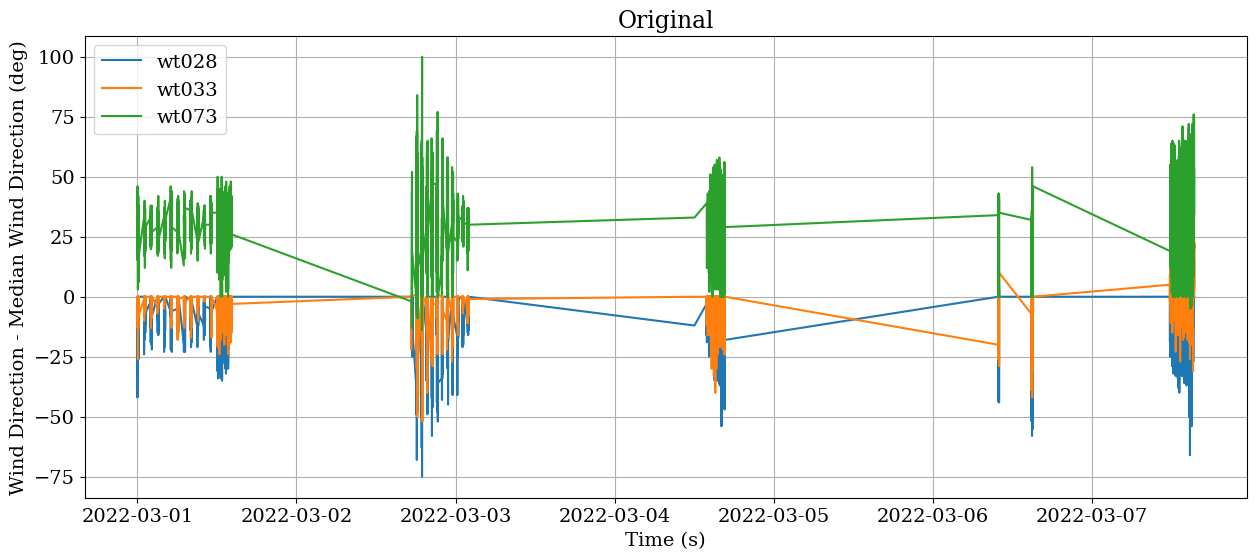

In [349]:
# turbine_ids = df_query.select("turbine_id").unique().collect(streaming=True).to_numpy()[:, 0]

# add the 3 degrees back to the wind direction signal
offset = 3.0
# ERIC WHY ADD OFFSET TODO
df_query2 = df_query.with_columns((cs.starts_with("wind_direction") + offset % 360.0))

wd_median = np.median(df_query2.select(cs.starts_with("wind_direction")).collect().to_numpy(), axis=1)
wd_median = np.degrees(np.arctan2(np.sin(np.radians(wd_median)), np.cos(np.radians(wd_median))))
wd_median = df_query2.select("time", cs.starts_with("wind_direction"), cs.starts_with("power_output")).with_columns(wd_median=wd_median)

yaw_median = np.median(df_query2.select(cs.starts_with("nacelle_direction")).collect().to_numpy(), axis=1)
yaw_median = np.degrees(np.arctan2(np.sin(np.radians(yaw_median)), np.cos(np.radians(yaw_median))))
yaw_median = df_query2.select("time", cs.starts_with("nacelle_direction"), cs.starts_with("power_output")).with_columns(yaw_median=yaw_median)

fig, ax = plt.subplots(1, 1)
for turbine_id in turbine_ids:
    df = df_query2.filter(pl.col(f"power_output_{turbine_id}") >= 0).select("time", f"wind_direction_{turbine_id}").collect()
                        
    ax.plot(df.select("time").to_numpy().flatten(), 
            DataFilter.wrap_180(
                        (df.select(f"wind_direction_{turbine_id}")
                        - wd_median.filter(pl.col(f"power_output_{turbine_id}") >= 0).select(f"wd_median").collect()).to_numpy().flatten()),
                        label=f"{turbine_id}")

ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Wind Direction - Median Wind Direction (deg)")

ax.set_title("Original")

In [354]:
df_offsets = {"turbine_id": [], "northing_bias": []}

# remove biases from median direction
for turbine_id in data_loader.turbine_ids:
    df = df_query2.filter(pl.col(f"power_output_{turbine_id}") >= 0)\
                  .select("time", f"wind_direction_{turbine_id}", f"nacelle_direction_{turbine_id}").collect()
                   
    wd_bias = DataFilter.wrap_180(DataFilter.circ_mean(
        (df.select(f"wind_direction_{turbine_id}")
                                    - wd_median.filter(pl.col(f"power_output_{turbine_id}") >= 0).select(f"wd_median").collect()).to_numpy().flatten()))
    yaw_bias = DataFilter.wrap_180(DataFilter.circ_mean(
        (df.select(f"nacelle_direction_{turbine_id}")
                                    - yaw_median.filter(pl.col(f"power_output_{turbine_id}") >= 0).select(f"yaw_median").collect()).to_numpy().flatten()))

    df_offsets["turbine_id"].append(turbine_id)
    df_offsets["northing_bias"].append(np.round(0.5 * (wd_bias + yaw_bias), 2))
    
    # TODO QUESTION ERIC how to know if some turbines need exceptional cases??
    offset = -0.5 * (wd_bias + yaw_bias)
    df = df.with_columns((pl.col(f"wind_direction_{turbine_id}") + offset) % 360.0, (pl.col(f"nacelle_direction_{turbine_id}") + offset) % 360.0)

    print(f"Turbine {turbine_id} bias from median wind direction: {df_offsets['northing_bias'][-1]} deg.")

df_offsets = pl.DataFrame(df_offsets)
# handle special case of turbine 39 with a couple change points
"""
tid = "wd_040"
df = DataInspector.collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == tid) & (pl.col("power_output") >= 0)))
wd_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] <= "2021-06-09 19:30") 
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-06-09 19:30")
            & (wd_median['time'] <= "2021-09-14 19:50")   
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-09-14 20:00")
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] <= "2021-06-09 19:30") 
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-06-09 19:30")
            & (yaw_median['time'] <= "2021-09-14 19:50")   
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-09-14 20:00")
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

cond = (df['time'] <= "2021-06-09 19:30")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360
df.loc[cond, "nacelle_direction"] = (df[cond, "nacelle_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360

cond = (df['time'] >= "2021-06-09 19:40") & (df['time'] <= "2021-09-14 19:50")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360

cond = (df['time'] >= "2021-09-14 20:00")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360

print("Biases from median wind direction for turbine 39:")

print(f"wd_bias_1: {wd_bias_1}")
print(f"wd_bias_2: {wd_bias_2}")
print(f"wd_bias_3: {wd_bias_3}")

print(f"yaw_bias_1: {yaw_bias_1}")
print(f"yaw_bias_2: {yaw_bias_2}")
print(f"yaw_bias_3: {yaw_bias_3}")

plt.figure()
for turbine_id in turbine_ids:
    plt.plot(df["time"], 
    DataFilter.wrap_180(df["wind_direction"].values - wd_median.loc[wd_median[f"power_output_{turbine_id}"] >= 0, "wind_direction"].values))

plt.xlabel("Time (s)")
plt.ylabel("Wind Direction - Median Wind Direction (deg)")
plt.title("Corrected")

# specific time of changepoints for turbine 39: 6/9 19:35:55; 9/14 19:55:02
"""
# make sure we have corrected the bias between wind direction and yaw position by adding 3 deg. to the wind direction
bias = 0
for turbine_id in turbine_ids:
    df = df_query2.filter(pl.col(f"power_output_{turbine_id}") >= 0)\
                  .select("time", f"wind_direction_{turbine_id}", f"nacelle_direction_{turbine_id}")
                  
    bias += DataFilter.wrap_180(DataFilter.circ_mean(df.select(pl.col(f"wind_direction_{turbine_id}") - pl.col(f"nacelle_direction_{turbine_id}")).collect().to_numpy().flatten()))
    
print(f"Average Bias = {bias / len(turbine_ids)}")

Turbine wt028 bias from median wind direction: -5.2 deg.
Turbine wt033 bias from median wind direction: 0.16 deg.
Turbine wt073 bias from median wind direction: 30.13 deg.
Average Bias = -0.021215282997289437


### Find offset to true North using wake loss profiles

In [355]:
# Optimization function for finding waked direction
def gauss_corr(gauss_params, power_ratio):
    xs = np.array(range(-int((len(power_ratio) - 1) / 2), int((len(power_ratio) + 1) / 2), 1))
    gauss = -1 * gauss_params[2] * np.exp(-0.5 * ((xs - gauss_params[0]) / gauss_params[1])**2) + 1.
    return -1 * np.corrcoef(gauss, power_ratio)[0, 1]

In [362]:
# TODO Find offsets between direction of alignment between pairs of turbines 
# and direction of peak wake losses. Use the average offset found this way 
# to identify the Northing correction that should be applied to all turbines 
# in the wind farm.
from scipy.stats import norm
from scipy.optimize import minimize

from floris import FlorisModel
fi = FlorisModel(data_inspector.farm_input_filepath)

def compute_offsets(df, turbine_pairs:list[tuple[int, int]]=None):
    p_min = 100
    p_max = 2500

    prat_hfwdth = 30

    prat_turbine_pairs = turbine_pairs or [(61,60), (51,50), (43,42), (41,40), (18,19), (34,33), (17,16), (21,22), (87,86), (62,63), (32,33), (59,60), (42,43)]

    dir_offsets = []

    for i in range(len(prat_turbine_pairs)):
        i_up = prat_turbine_pairs[i][0]
        i_down = prat_turbine_pairs[i][1]

        dir_align = np.degrees(np.arctan2(fi.layout_x[i_up] - fi.layout_x[i_down], fi.layout_y[i_up] - fi.layout_y[i_down])) % 360

        # df_sub = df_10min.loc[(df_10min['pow_%03d' % i_up] >= p_min) & (df_10min['pow_%03d' % i_up] <= p_max) & (df_10min['pow_%03d' % i_down] >= 0)]
        tid_up =  f'wt{i_up:03d}'
        tid_down =  f'wt{i_down:03d}'

        if not (any(tid_up in feat for feat in data_loader.available_features) and any(tid_down in feat for feat in data_loader.available_features)):
            continue

        df_sub = df.filter((pl.col(f"power_output_{tid_up}") >= p_min) 
                                & (pl.col(f"power_output_{tid_up}") <= p_max) 
                                & (pl.col(f"power_output_{tid_down}") >= 0))
        
        # df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] = df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] - 360.0
        df_sub = df_sub.with_columns(pl.when((pl.col(f"wind_direction_{tid_up}") >= 359.5))\
                                        .then(pl.col(f"wind_direction_{tid_up}") - 360.0)\
                                        .otherwise(pl.col(f"wind_direction_{tid_up}")))

        # df_sub["wd_round"] = df_sub[f'wd_{i_up:03d}'].round()
        df_sub = df_sub.with_columns(pl.col(f"wind_direction_{tid_up}").round().alias(f"wd_round_{tid_up}"))

        df_sub = df_sub.group_by(f"wd_round_{tid_up}").mean().collect()

        p_ratio = df_sub.select(pl.col(f"power_output_{tid_down}") / pl.col(f"power_output_{tid_up}")).collect().to_numpy().flatten()

        plt.figure()
        _, ax = plt.subplots(1,1)
        ax.plot(p_ratio, label="_nolegend_")
        ax.plot(dir_align * np.ones(2),[0,1.25], 'k--', label="Direction of Alignment")
        ax.grid()

        nadir = np.argmin(p_ratio[np.arange(int(np.round(dir_align)) - prat_hfwdth, int(np.round(dir_align)) + prat_hfwdth + 1) % 360])
        nadir = nadir + int(np.round(dir_align)) - prat_hfwdth

        opt_gauss_params = minimize(gauss_corr, [0, 5.0, 1.0], args=(p_ratio[np.arange(nadir - prat_hfwdth, nadir + prat_hfwdth + 1) % 360]),method='SLSQP')

        xs = np.array(range(-int((60 - 1) / 2),int((60 + 1) / 2),1))
        gauss = -1 * opt_gauss_params.x[2] * np.exp(-0.5 * ((xs - opt_gauss_params.x[0]) / opt_gauss_params.x[1])**2) + 1.

        ax.plot(xs + nadir, gauss,'k',label="_nolegend_")
        ax.plot(2 * [nadir + opt_gauss_params.x[0]], [0,1.25], 'r--',label="Direction of Measured Wake Center")
        ax.title(f"Turbine Pair: ({i_up}, {i_down})")
        ax.legend()
        ax.xlabel("Wind Direction [deg]")
        ax.ylabel("Power Ratio [-]")
        
        dir_offset = DataFilter.wrap_180(nadir + opt_gauss_params.x[0] - dir_align)
        print(dir_offset)

        dir_offsets = dir_offsets + [dir_offset]

    if dir_offsets:
        print(f"Mean offset = {np.mean(dir_offsets)}")
        print(f"Std. Dev. = {np.std(dir_offsets)}")
        print(f"Min. = {np.min(dir_offsets)}")
        print(f"Max. = {np.max(dir_offsets)}")
    else:
        print("No available turbine pairs!")

compute_offsets(df_query2)

No available turbine pairs!


In [363]:
# Apply Northing offset to each turbine
for turbine_id in data_loader.turbine_ids:
    df_query2.with_columns((pl.col(f"wind_direction_{turbine_id}") - np.mean(dir_offsets)) % 360)
    df_query2.with_columns((pl.col(f"nacelle_direction_{turbine_id}") - np.mean(dir_offsets)) % 360)

2024-10-18 17:00:31,814 - WARNING - /Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2024-10-18 17:00:31,815 - WARNING - /Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



In [ ]:
# TODO Determine final wind direction correction for each turbine
df_offsets = df_offsets.with_columns(DataFilter.wrap_180(pl.col("northing_bias") + np.mean(dir_offsets)).round(2))

# df_offsets = df_offsets.set_index("Turbine ID")

print("wd_bias_1: "+str(np.round(0.5*(wd_bias_1+yaw_bias_1) + np.mean(dir_offsets),2)))
print("wd_bias_2: "+str(np.round(0.5*(wd_bias_2+yaw_bias_2) + np.mean(dir_offsets),2)))
print("wd_bias_3: "+str(np.round(0.5*(wd_bias_3+yaw_bias_3) + np.mean(dir_offsets),2)))

df_offsets.head()

In [ ]:
# verify that Northing calibration worked properly
compute_offsets(df_query2)

## Normalization